In [ ]:
!pip install torch==2.2.1 torchvision torchaudio

INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 89.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 42.2 MB/s eta 0:00:00

In [ ]:
!pip install --upgrade diffusers
!pip install -q transformers accelerate controlnet_aux opencv-python ipywidgets

In [ ]:
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Function to upload an image
def upload_image():
    uploaded = files.upload()
    for filename in uploaded.keys():
        img = Image.open(filename)
        return img, filename

# Function to preprocess sketch for ControlNet
def preprocess_sketch(image):
    # Resize to 512x512 or keep aspect ratio but limit max dimension
    w, h = image.size
    if max(w, h) > 1024:
        ratio = min(512 / w, 512 / h)
        new_w, new_h = int(w * ratio), int(h * ratio)
        image = image.resize((new_w, new_h), Image.LANCZOS)

    # Convert to numpy array for processing
    image_np = np.array(image)

    # Check if image is grayscale already
    if len(image_np.shape) == 3 and image_np.shape[2] == 3:
        # For sketches, we want to enhance edges
        gray_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    else:
        gray_image = image_np

    # Convert back to RGB (required for the model)
    processed_image = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    processed_pil = Image.fromarray(processed_image)

    return processed_pil

# Function to visualize results
def visualize_results(original, result):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title("Original Sketch")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(result)
    plt.title("Generated Image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Main function to process image with diffusion model
def sketch_to_image(sketch_image, prompt, negative_prompt="", num_inference_steps=20, guidance_scale=7.5):
    try:
        # Determine device and precision
        device = "cuda" if torch.cuda.is_available() else "cpu"
        dtype = torch.float16 if device == "cuda" else torch.float32
        print(f"Using device: {device} with {dtype} precision")

        # For CPU, reduce complexity to speed up
        if device == "cpu":
            print("CPU detected. Using lower resolution and fewer steps for faster processing.")
            num_inference_steps = min(num_inference_steps, 20)  # Limit steps on CPU

        # Load ControlNet model for sketch conditioning
        print("Loading ControlNet model...")
        controlnet = ControlNetModel.from_pretrained(
            "lllyasviel/sd-controlnet-scribble",
            torch_dtype=dtype
        )

        # Load Stable Diffusion pipeline with ControlNet
        print("Loading Stable Diffusion pipeline...")
        pipe = StableDiffusionControlNetPipeline.from_pretrained(
            "runwayml/stable-diffusion-v1-5",
            controlnet=controlnet,
            torch_dtype=dtype,
            safety_checker=None  # Disable safety checker for faster processing
        )

        pipe = pipe.to(device)


        if device == "cuda":
            print("Using attention slicing for GPU memory efficiency")
            pipe.enable_attention_slicing()


        pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)


        processed_sketch = preprocess_sketch(sketch_image)


        print(f"Generating image with {num_inference_steps} steps (this may take a while on CPU)...")
        result = pipe(
            prompt=prompt,
            negative_prompt=negative_prompt,
            image=processed_sketch,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale
        ).images[0]

        visualize_results(sketch_image, result)

        return result

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise e


Please upload your sketch image:


Saving how-to-draw-a-cartoon-light-bulb-step-by-step.jpg.webp to how-to-draw-a-cartoon-light-bulb-step-by-step.jpg (3).webp
Processing your sketch...
Enter a prompt describing the desired output (e.g., 'a colorful landscape with mountains and trees, realistic, detailed'): trees coming out of dark bulb
Enter negative prompt (optional, e.g., 'blurry, low quality'): bad quality
Using device: cpu with torch.float32 precision
CPU detected. Using lower resolution and fewer steps for faster processing.
Loading ControlNet model...
Loading Stable Diffusion pipeline...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Generating image with 20 steps (this may take a while on CPU)...


  0%|          | 0/20 [00:00<?, ?it/s]

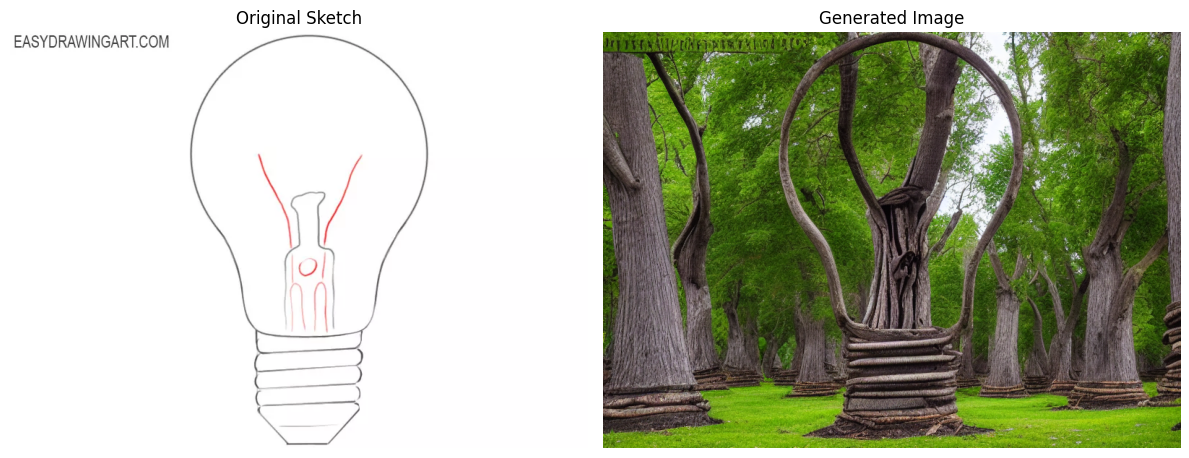

Generated image saved as generated_how-to-draw-a-cartoon-light-bulb-step-by-step.jpg (3).webp


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

print("Please upload your sketch image:")
sketch, filename = upload_image()

print("Processing your sketch...")
prompt = input("Enter a prompt describing the desired output (e.g., 'a colorful landscape with mountains and trees, realistic, detailed'): ")
negative_prompt = input("Enter negative prompt (optional, e.g., 'blurry, low quality'): ")

result_image = sketch_to_image(
    sketch_image=sketch,
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=20,
    guidance_scale=7.5
)

output_filename = f"generated_{filename}"
result_image.save(output_filename)
print(f"Generated image saved as {output_filename}")
files.download(output_filename)